In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#import shap
import pickle
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

In [2]:
plt.rcParams["mathtext.fontset"]
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [3]:
transaction_frequency_opcode = ['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in', 
 'payment_out', 'investment_to_contract/tx_in', 'payment_from_contract/tx_out', 
 '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate', 
 'paid_one', 'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'owner_gets_eth_Wo_investing',
 'owner_gets_eth_investing', 'owner_no_eth', 'PUSH', 'INVALID', 'DUP', 'JUMPDEST', 'STOP', 'MSTORE', 'JUMPI', 'REVERT', 'CALLVALUE',
 'ISZERO', 'CODECOPY', 'RETURN', 'LOG', 'SHA3', 'MSTORE8', 'SWAP', 'POP', 'ADD', 'MLOAD', 'AND', 'SUB', 'CALLDATALOAD', 'EXP', 
 'MUL', 'SLOAD', 'EQ', 'JUMP', 'DIV', 'CALLER', 'CALLDATACOPY', 'SSTORE', 'NOT', 'CALL', 'LT', 'GT', 'OR', 'ADDRESS2', 'TIMESTAMP', 
 'GASLIMIT', 'GAS', 'ORIGIN', 'BALANCE3', 'CALLDATASIZE', 'SAR', 'MSIZE', 'CODESIZE', 'COINBASE', 'CREATE2', 'EXTCODESIZE', 'CALLCODE', 'SHL',
 'BLOCKHASH', 'RETURNDATASIZE', 'SHR', 'GETPC', 'DELEGATECALL', 'MOD', 'ADDMOD', 'NUMBER', 'XOR', 'SLT', 'EXTCODECOPY', 'MULMOD', 'CREATE', 'SELFDESTRUCT', 
 'STATICCALL', 'RETURNDATACOPY', 'SGT', 'DIFFICULTY', 'SMOD', 'BYTE', 'SIGNEXTEND', 'CHAINID', 'SELFBALANCE', 'GASPRICE', 'EXTCODEHASH', 'SDIV', 'target']

In [4]:
dataset_path = ("\\Users\\lucap\\OneDrive\\Desktop\\Smart Ponzi\\bytecode_opcode_8k.csv")
db = pd.read_csv(dataset_path, header = 0, delimiter = ';')
db = db.fillna(0)

In [5]:
df_transaction_weighted_opcode = db[transaction_frequency_opcode].copy()
y = df_transaction_weighted_opcode.loc[:, ['target']].values
y = pd.DataFrame(y,columns=['target'])

dataset_account = db.iloc[:, 0:24] 
dataset_opcode = db.iloc[:, 24:101] 

dataset_opcode['all_opcode'] = dataset_opcode[list(dataset_opcode.columns)].sum(axis=1) #generate all_opcode
dataset_opcode = dataset_opcode[:].div(dataset_opcode['all_opcode'], axis=0)
dataset_opcode = dataset_opcode.drop(['all_opcode'], axis = 1)

df_transaction_weighted_opcode = pd.concat([dataset_account, dataset_opcode, y], axis=1)
df_transaction_weighted_opcode = df_transaction_weighted_opcode.fillna(0)

In [13]:
col_name = transaction_frequency_opcode[1:-1]

In [14]:
X = df_transaction_weighted_opcode.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = df_transaction_weighted_opcode.loc[:, ['target']].values

X = pd.DataFrame(X)
X.columns = col_name

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42, stratify=y) 

In [17]:
params =[

        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1], #[0.1,0.01]
            'classifier__n_estimators' : [100], #[80, 100, 120]
            'classifier__max_depth' : [15], #[10,15,20],
            'classifier__colsample_bytree' : [0.5], #[0.5,0.8,1],
            'classifier__reg_alpha' : [0], #[0, 0.1, 0.2],
            'classifier__reg_lambda' : [1], #[1,10,15],
        }
]

In [18]:
data = {}
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(pipeline, params, cv=5,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [LGBMClassifier(colsample_bytree=0.5,
                                                        max_depth=15, n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0,
                                                        reg_lambda=1)],
                          'classifier__colsample_bytree': [0.5],
                          'classifier__learning_rate': [0.1],
                          'classifier__max_depth': [15],
                          'classifier__n_estimators': [100],
                          'classifier__reg_alpha': [0],
                          'classifier__reg_lambda': [1]}],
             return_train_score=True, scoring='roc_auc', verbose=2)

In [19]:
print(grid_search.best_params_)
print('Test accuracy: %.3f' % grid_search.score(X_test, y_test))

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_jobs=4, random_state=42,
               reg_alpha=0, reg_lambda=1), 'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1}
Test accuracy: 0.964


In [20]:
data = {}
y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]   
# Confusion matrix 
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

In [21]:
data

{'best_precision_training': [0.9974554707379135],
 'best_recall_training': [0.9874055415617129],
 'best_accuracy_training': [0.9982266883404758],
 'best_f1_training': [0.9924050632911393],
 'best_precision_test': [0.8974358974358975],
 'best_recall_test': [0.75],
 'best_accuracy_test': [0.9606694560669456],
 'best_f1_test': [0.8171206225680935]}

In [22]:
cls = grid_search.best_estimator_

In [23]:
df_X_train_full = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[1:-1])
df_transaction_weighted_opcode.isnull().sum().sum()

,balance,lifetime,tx_in,tx_out,investment_in,payment_out,investment_to_contract/tx_in,payment_from_contract/tx_out,#addresses_paying_contract,#addresses_paid_by_contract,...,SGT,DIFFICULTY,SMOD,BYTE,SIGNEXTEND,CHAINID,SELFBALANCE,GASPRICE,EXTCODEHASH,SDIV
7255,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000535,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
5605,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
5375,0.0,12.0,3732.0,3730.0,3730.0,3730.0,0.9995,1.0,3360.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
6936,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
6150,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,0.0,0.0,2.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000458
6947,0.0,1328.0,5396.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0004,0.000000,0.0,0.000200
5025,0.0,1.0,7.0,32.0,6.0,32.0,0.8571,1.0,4.0,7.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
4541,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000286,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000


In [25]:
cross_validations = {}

df_cross_validations = pd.DataFrame()

df_X_train_full = X_train
df_X_test_full = X_test
# model = grid_search.best_estimator_
model = grid_search
auc_scores = {'n_features':[],'auc_score':[]}
for i in range(len(df_X_train_full.columns),10,-1):
    rfe = RFE(model,n_features_to_select=i)
    rfe = rfe.fit(df_X_train_full, y_train.ravel())

# summarize the selection of the attributes
#     print(rfe.support_)
#     print(rfe.ranking_)
    print(set(rfe.feature_names_in_).difference(rfe.get_feature_names_out()))
    X_train_transformed = rfe.transform(df_X_train_full)
    X_test_transformed = rfe.transform(df_X_test_full)
    
    df_X_train_full = pd.DataFrame(X_train_transformed,columns=rfe.get_feature_names_out())
    df_X_test_full = pd.DataFrame(X_test_transformed,columns=rfe.get_feature_names_out())
    
    pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

    params =[
       # {
       #     'classifier': [DecisionTreeClassifier(random_state=42)],
       #     'classifier__criterion' : ['entropy', 'gini'],
       #     'classifier__max_depth' : [5, 6, 7, 8, 9],
       #     'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
       #     'classifier__max_features' : range(6,X_train_transformed.shape[1],3),
       #     'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
       # },
       # {
       #     'classifier': [RandomForestClassifier(random_state=42)],
       #     'classifier__n_estimators':[150, 175, 200, 225, 250],
       #     'classifier__min_samples_split' : [5,15,30],
       #     'classifier__criterion':['gini', 'entropy'],
       #     'classifier__class_weight' : [{0:1, 1:5.5}],
       #     'classifier__bootstrap': [True, False]
       # },
             {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1,0.01], 
            'classifier__n_estimators' :  [80, 100, 120, 140],
            'classifier__max_depth' :  [10,15],
            'classifier__colsample_bytree' : [0.5,0.8], 
            'classifier__reg_alpha' :  [0, 0.1],
            'classifier__reg_lambda' :  [1,10]
        }



     ]
    grid_search = GridSearchCV(pipeline, params, cv=5,
                           scoring='roc_auc',
                           return_train_score=True,n_jobs=4)
    grid_search.fit(df_X_train_full, y_train.ravel())
    cross_validations[i] = grid_search 
    _tmp_cv = pd.DataFrame(grid_search.cv_results_)
    _tmp_cv['n_features'] = i
    _tmp_cv['features'] = ','.join([column for column in rfe.get_feature_names_out() ])
    
    df_cross_validations = pd.concat([df_cross_validations,_tmp_cv])
    
    model = grid_search.best_estimator_.named_steps['classifier']
    model.fit(df_X_train_full,y_train.ravel())
    y_pred_proba = model.predict_proba(df_X_test_full)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
    auc_score = roc_auc_score(y_test,y_pred_proba)
    print(auc_score)
    auc_scores['n_features'].append(i)
    auc_scores['auc_score'].append(auc_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
set()
0.9642484766418417
{'owner_gets_eth_investing'}
0.9653520649966147
{'CALLCODE'}
0.9678436018957346
{'payment_from_contract/tx_out'}
0.9662051455653352
{'MSTORE8'}
0.9660358835477318
{'SHL'}
0.9652640487474611
{'MULMOD'}
0.9679790115098172
{'SELFBALANCE'}
0.9679993229519297
{'SAR'}
0.9618381855111713
{'EXTCODEHASH'}
0.9651624915368991
{'GETPC'}
0.9642281651997292
{'CHAINID'}
0.96406567366283
{'EXTCODECOPY'}
0.9639438050101558
{'ADDMOD'}
0.9659749492213947
{'GASLIMIT'}
0.9674983073798241
{'ORIGIN'}
0.9689607312119161
{'SIGNEXTEND'}
0.9637068381855112
{'BYTE'}
0.9691909275558566
{'GASPRICE'}
0.967132701421801
{'CREATE2'}
0.9649661475964793
{'payment_out'}
0.9649119837508463
{'sdev_tx_out'}
0.9680534867975625
{'owner_gets_eth_Wo_investing'}
0.9658124576844956
{'COINBASE'}
0.9636255924170617
{'investment_in'}
0.9693669600541639
{'DIFFICULTY'}
0.9677217332430602
{'SHR'}
0.9672071767095464
{'XOR'}
0.9656567366283006
{'STATICCALL

In [27]:

df_cross_validations.sort_values('mean_test_score',ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__reg_alpha,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
13,3.52328,0.160385,0.013077,0.002445,"LGBMClassifier(colsample_bytree=0.5, max_depth...",0.5,0.1,10,140,0,...,1,0.999699,0.999717,0.999676,0.999667,0.999712,0.999694,0.00002,99,"balance,lifetime,tx_in,tx_out,investment_in,pa..."


In [29]:
pd.set_option('display.max_columns', None)

Ho selezionato il 'terzo' migliore in quanto le performance erano allineate ma la terza scelta utilizzava meno della metà delle features

In [32]:
df_cross_validations.sort_values('mean_test_score',ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__reg_alpha,param_classifier__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
13,3.523280,0.160385,0.013077,0.002445,"LGBMClassifier(colsample_bytree=0.5, max_depth...",0.5,0.1,10,140,0,10,{'classifier': LGBMClassifier(colsample_bytree...,0.974514,0.970003,0.971819,0.983355,0.984291,0.976797,0.005921,1,0.999699,0.999717,0.999676,0.999667,0.999712,0.999694,0.000020,99,"balance,lifetime,tx_in,tx_out,investment_in,pa..."
9,2.889769,0.179832,0.011761,0.000775,"LGBMClassifier(colsample_bytree=0.5, max_depth...",0.5,0.1,10,120,0,10,{'classifier': LGBMClassifier(colsample_bytree...,0.974388,0.970161,0.971440,0.983508,0.984233,0.976746,0.005981,2,0.999527,0.999569,0.999481,0.999474,0.999528,0.999516,0.000035,99,"balance,lifetime,tx_in,tx_out,investment_in,pa..."
15,3.180837,0.134128,0.009469,0.000890,"LGBMClassifier(colsample_bytree=0.5, max_depth...",0.5,0.1,10,140,0.1,10,{'classifier': LGBMClassifier(colsample_bytree...,0.975282,0.963893,0.974332,0.985883,0.981797,0.976237,0.007495,1,0.999466,0.999593,0.999513,0.999498,0.999668,0.999547,0.000073,43,"balance,lifetime,tx_in,investment_to_contract/..."


In [42]:
tab_res_ = df_cross_validations.sort_values('mean_test_score',ascending=False).head(3)

In [44]:
tab_res_ = tab_res_.tail(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__reg_alpha,param_classifier__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
15,3.180837,0.134128,0.009469,0.00089,"LGBMClassifier(colsample_bytree=0.5, max_depth...",0.5,0.1,10,140,0.1,10,{'classifier': LGBMClassifier(colsample_bytree...,0.975282,0.963893,0.974332,0.985883,0.981797,0.976237,0.007495,1,0.999466,0.999593,0.999513,0.999498,0.999668,0.999547,0.000073,43,"balance,lifetime,tx_in,investment_to_contract/..."


In [45]:
best_features_set = df_cross_validations.sort_values('mean_test_score',ascending=False).head(3)['features'].values[2]

In [46]:
best_features_set

'balance,lifetime,tx_in,investment_to_contract/tx_in,sdev_v2,paid_rate,PUSH,INVALID,DUP,JUMPDEST,STOP,JUMPI,REVERT,CALLVALUE,ISZERO,CODECOPY,RETURN,LOG,SHA3,SWAP,POP,ADD,MLOAD,AND,SUB,CALLDATALOAD,EXP,MUL,SLOAD,JUMP,DIV,CALLER,SSTORE,NOT,CALL,LT,GT,OR,TIMESTAMP,GAS,BALANCE3,CALLDATASIZE,RETURNDATASIZE'

In [47]:
best_features_set = best_features_set.split(',')

In [48]:
best_features_set

['balance',
 'lifetime',
 'tx_in',
 'investment_to_contract/tx_in',
 'sdev_v2',
 'paid_rate',
 'PUSH',
 'INVALID',
 'DUP',
 'JUMPDEST',
 'STOP',
 'JUMPI',
 'REVERT',
 'CALLVALUE',
 'ISZERO',
 'CODECOPY',
 'RETURN',
 'LOG',
 'SHA3',
 'SWAP',
 'POP',
 'ADD',
 'MLOAD',
 'AND',
 'SUB',
 'CALLDATALOAD',
 'EXP',
 'MUL',
 'SLOAD',
 'JUMP',
 'DIV',
 'CALLER',
 'SSTORE',
 'NOT',
 'CALL',
 'LT',
 'GT',
 'OR',
 'TIMESTAMP',
 'GAS',
 'BALANCE3',
 'CALLDATASIZE',
 'RETURNDATASIZE']

In [49]:
best_param_set = df_cross_validations['param_classifier'].values[2]

In [59]:
df_cross_validations[:].values[2]

array([4.577961349487305, 0.06312943449747284, 0.021843767166137694,
       0.002562651347059224,
       LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=140, n_jobs=4,
                      random_state=42, reg_alpha=0.1, reg_lambda=10)                 ,
       0.5, 0.1, 10, 80, 0.1, 1,
       {'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=140, n_jobs=4,
                      random_state=42, reg_alpha=0.1, reg_lambda=10), 'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 80, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1},
       0.971877055866951, 0.9633720165258809, 0.9712767190248939,
       0.9824120603015075, 0.9797044648058895, 0.9737284633050246,
       0.00674999555765499, 43, 0.9997804899753793, 0.9997831267324319,
       0.9997810301960841, 0.9997508785978024, 0.999797618013379,
       0.9997786287030154, 1.5232373549894671e-05, 100,
      

In [50]:
best_param_set

LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=140, n_jobs=4,
               random_state=42, reg_alpha=0.1, reg_lambda=10)

In [52]:
df_X_train_full = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

model.fit(df_X_train_full,y_train.ravel())
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba_best)    
auc_score = roc_auc_score(y_test,y_pred_proba_best)


y_pred_best = model.predict(df_X_test_full)
best_precision_test= precision_score(y_test, y_pred_best) # TP / (FP + TP)
best_recall_test = recall_score(y_test, y_pred_best)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test, y_pred_best)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test, y_pred_best)

#print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))

AUC: 0.966
Precision: 0.924
Recall: 0.779
Accuracy: 0.967
F1: 0.845


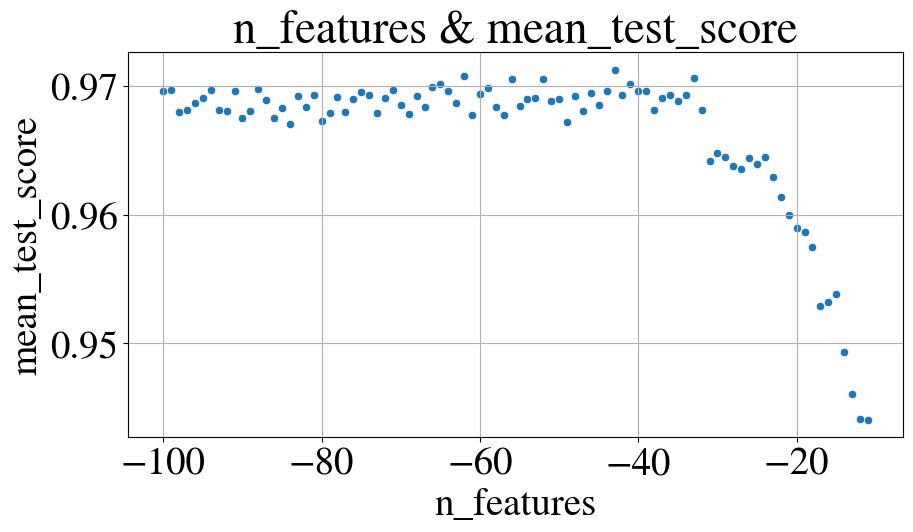

In [ ]:
plt.figure(figsize=(10,5))
plt.title('n_features & mean_test_score')
plt.xlabel('n_features')
plt.ylabel('mean_test_score')
sns.scatterplot(x= df_cross_validations['n_features'] * -1,y = df_cross_validations['mean_test_score'])
plt.grid() 
plt.show()